In [1]:
from typing import *
from sklearn.pipeline import Pipeline
from pandas import DataFrame
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook


def run_exp_period_genre(
    clf_pipelines: Pipeline,
    df: DataFrame,
    X_column: str = 'text',
    feat_decription: str = "Placeholder",
    pipeline_infos: List[str] = None,
    train_period: str = 'P1',
    verbose: bool = False):
    
    # init figure
    #fig, ax = plt.subplots(figsize=(7,7))
    #NUM_COLORS = len(df.genre.unique()) * len(clf_pipelines)
    #cm = plt.get_cmap('gist_rainbow')
    #ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    ##ax.set_color_cycle()
    
    if not pipeline_infos:
        pipeline_infos = [None for i in clf_pipelines]
    
    # build trainset
    df_train = df[df.period == train_period]
    
    
    # build testset
    # sort period labels so that the train period will be first 
    test_period_labels = sorted(df.period.unique().tolist())
    # swap train period to first place in list
    #ind = test_period_labels.index(train_period)
    #temp = test_period_labels[0]
    #test_period_labels[0] = test_period_labels[ind]
    #test_period_labels[ind] = temp
    #
    #test_period_labels = sorted(test_period_labels)

    test_period = [df[df.period == p] for p in test_period_labels]
    
    # loop over all pipes
    if verbose:
        iterator = tqdm_notebook(zip(clf_pipelines, pipeline_infos))
    else:
        iterator = zip(clf_pipelines, pipeline_infos)
    
    results = {}
    for clf_pipeline, pipeline_info in iterator:
        
        # 0.1 Some preperations
        if not pipeline_info:
            pipeline_info = clf_pipeline.steps[-1][0]
        
        # fit clf_pipeline
        clf_pipeline.fit(df_train[X_column], df_train.genre)
        
        periods_results = {}
        for df_period in test_period:
            
            y_pred = clf_pipeline.predict(df_period[X_column])
            
            report = classification_report(df_period.genre, y_pred, output_dict=True)
            periods_results[df_period.period.unique()[0]] = report
        
        
        results[pipeline_info] = periods_results
    
    return results, train_period    

In [2]:
import matplotlib.pyplot as plt

def plot_results(results: dict,
                 train_period: str,
                 feat_descripton: str,
                 genres: List[str] = ['DRAM', 'HUMA', 'LEGA', 'NARR', 'SCIE', 'SERM'],
                 periods: List[str] = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6']):
    
    figs, axs, filenames = [], [], []
        
    for genre in genres:

        #init figure for one genre
        fig, ax = plt.subplots()
        #NUM_COLORS = len(df.genre.unique()) * len(results)
        #cm = plt.get_cmap('gist_rainbow')
        #ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        ax.set_ylim([0,1])
        #ax.set_color_cycle()
        
        for clf_pipeline, reports in results.items():
            periods = []
            fscores = []
            for period, report in reports.items():
                
                periods.append(period)
                
                fscores.append(report[genre]['f1-score'])
        
            ax.plot(periods, fscores, label=f'{clf_pipeline}', zorder=1)
        
        #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.legend()
        ax.set_xlabel('Period')
        ax.set_ylabel('F1-Score')
        ax.set_title(f'Genre: {genre} | Train-Period: {train_period} | Features: {feat_descripton}')
        #fig.tight_layout()
        
        figs.append(fig)
        axs.append(ax)
        filenames.append(f'{genre}_{train_period}_{clf_pipeline}_{feat_descripton}')
        
    return figs, axs, filenames

In [47]:
import pandas as pd
df = pd.read_csv('full_taggeddataset.csv').dropna()
df = df[df.genre != 'NEWS']
df = df[df.genre != 'NEWS-P4']
print(df.genre.unique())
df.head()

['DRAM' 'HUMA' 'LEGA' 'NARR' 'SCIE' 'SERM']


,Unnamed: 0,tokens,pos_tags,lemmas,title,genre,period,region,year,corpus
0,0,So koͤmmet euch der LoͤwRitter schwermuͤtig vo...,ADV VVFIN PPER ART NE ADJD PTKVZ SENT ITJ PPER...,so kommen ihr d Löwritter schwermütig vor ? ja...,Leonilda.txt,DRAM,P1,NoD,1673,manchester
1,1,ARmes herz / laß ab zu hoffen / weil das gluͤc...,"ADJA NN $, VVIMP PTKVZ PTKZU VVINF $, KOUS PDS...",arm Herz / lassen ab zu hoffen / weil d glück ...,Euridice.txt,DRAM,P1,NoD,1699,manchester
2,2,ACh / ich bin schon so müde / das ich kaum meh...,"ITJ $, PPER VAFIN ADV ADV ADJD $, PRELS PPER A...",ach / ich sein schon so müde / d ich kaum mehr...,Freyheit.txt,DRAM,P1,NoD,1700,manchester
3,3,So ists ! er ließ mich hoch vnd uͤberhoch bela...,ADV VAFIN SENT PPER VVFIN PPER ADJD KON NN VVI...,so sein ! er lassen ich hoch und überhoch bela...,Cardenio.txt,DRAM,P1,OMD,1657,manchester
4,4,VErtraute Charmium / dis ist di Lebens-Hoͤle ;...,"NN NN $, PDS VAFIN FM NN SENT PDS VAFIN ART NN...",vertraute Charmium / dies sein -- Lebens-Höle ...,Cleopatra.txt,DRAM,P1,OMD,1661,manchester


In [42]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from stop_words import get_stop_words

pipe1 = make_pipeline(TfidfVectorizer(max_features=300), LogisticRegression())
pipe2 = make_pipeline(TfidfVectorizer(max_features=300), LinearSVC())
pipe3 = make_pipeline(TfidfVectorizer(max_features=300), MultinomialNB())
pipe4 = make_pipeline(TfidfVectorizer(max_features=300), DecisionTreeClassifier())
pipe5 = make_pipeline(TfidfVectorizer(max_features=300), RandomForestClassifier())
pipe6 = make_pipeline(TfidfVectorizer(max_features=300), XGBClassifier())




pipes = [pipe1, pipe2, pipe3]#, pipe4, pipe5]#, pipe6]

In [43]:
results, train_period = run_exp_period_genre(pipes,df, train_period='P1', verbose=True, X_column='text')

/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.


In [44]:
results

{'logisticregression': {'P1': {'DRAM': {'precision': 0.875,
    'recall': 0.9333333333333333,
    'f1-score': 0.9032258064516129,
    'support': 15},
   'HUMA': {'precision': 0.7647058823529411,
    'recall': 0.8666666666666667,
    'f1-score': 0.8125,
    'support': 15},
   'LEGA': {'precision': 0.8235294117647058,
    'recall': 0.9333333333333333,
    'f1-score': 0.8749999999999999,
    'support': 15},
   'NARR': {'precision': 0.8461538461538461,
    'recall': 0.7333333333333333,
    'f1-score': 0.7857142857142856,
    'support': 15},
   'SCIE': {'precision': 0.9230769230769231,
    'recall': 0.8,
    'f1-score': 0.8571428571428571,
    'support': 15},
   'SERM': {'precision': 0.8571428571428571,
    'recall': 0.8,
    'f1-score': 0.8275862068965518,
    'support': 15},
   'accuracy': 0.8444444444444444,
   'macro avg': {'precision': 0.8482681534152121,
    'recall': 0.8444444444444444,
    'f1-score': 0.8435281927008845,
    'support': 90},
   'weighted avg': {'precision': 0.8482681

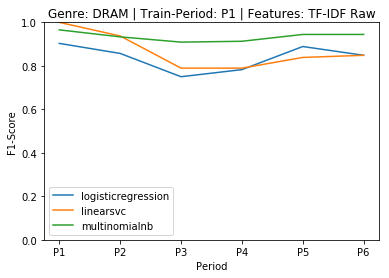

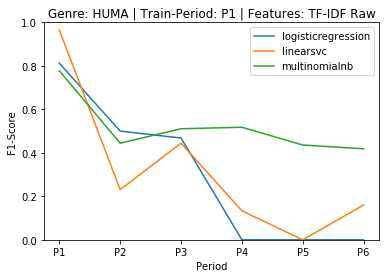

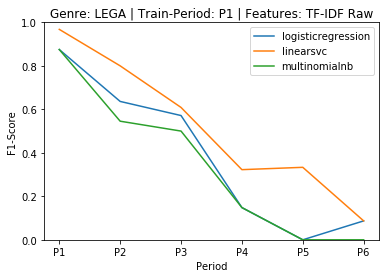

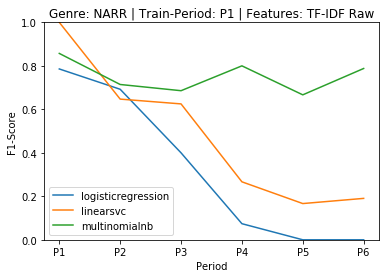

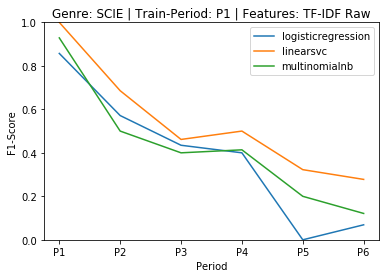

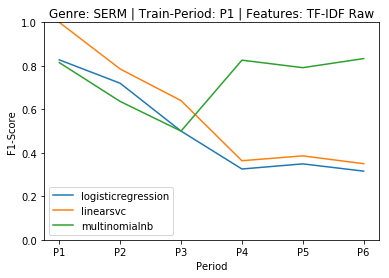

In [45]:
figs, axs, filenames = plot_results(results, train_period, 'TF-IDF Raw')

In [46]:
for fig, fn in zip(figs, filenames):
    fig.savefig(f'plots/test/{train_period}_300MFq/{fn}.png', dpi=200)

In [30]:
bools = []
for lemmas, tokens, pos_tags in zip(df.lemmas, df.tokens, df.pos_tags):
    bools.append(len(lemmas.split()) == len(tokens.split()) == len(pos_tags.split()))

In [35]:
bools.index(False)

13

In [36]:
df.iloc[13]

Unnamed: 0                                                   13
tokens        Was beduncket euch / unsers Reiches veste Grun...
pos_tags      PWS VVFIN PPER $, PPOSAT NN ADJA NN SENT VMFIN...
lemmas        was beduncket ihr / unser Reich fest Grund-Säu...
title                                                Joseph.txt
genre                                                      DRAM
period                                                       P1
region                                                      WOD
year                                                       1687
corpus                                               manchester
Name: 13, dtype: object

In [39]:
def concat_with_postags(pos_tags, tokens):
    result = []
    for tag, token in zip(pos_tags, tokens):
        result.append(f'{token}_{pos_tags}')
    return result

In [38]:
for x, y in zip(range(2), range(1)):
    print(x,y)

0 0


In [ ]:
pos_tags_lemmas = [
    concat_with_postags(pos_tags.split(), lemmas.split()) for pos_tags, lemmas in zip(df.pos_tags, df.lemmas)
]

In [ ]:
len(pos_tags_lemmas)

In [69]:
s = " ".join(df.lemmas)

In [70]:
s[:2000]

'so kommen ihr d Löwritter schwermütig vor ? ja ich können nicht ander schließen / weil er stets in tief Gedanke sitzen . vielleicht sein er noch ermüden von d viel beschwerlich Reise und abenteuerlich Begebenheit . lassen er wohl pflegen / damit er er|es|sie wieder erholen . daran mangeln er nichts . vielleicht sein er verlieben . davor halten ich er gänzlich : denn er klagen immer / d schön Sonne d Welt haben ihr Glanz bisher vor er verdecken / und wenn er derselbe nicht genießen können / so müssen er vor Leid vergehen . haben Ihr dann nicht merken können / was er durch sein Sonne verstehen ? davon haben ich eigentlich nichts erfahren können ; aber in sein Gemach henget ein gülden Sonne / in d Mitte ein künstlich L. von d köstlich Diamant versetzen sein . d werden wohl sein Ritterzeichen sein . davor halten ich es nicht ; denn ich zu mehrenmal er vor d Sonne auf d Knie sitzend und derselbe anbetend finden . können man denn nicht erfahren / wessen Stand dies Ritter sein ? solch haben 

In [71]:
t = TfidfVectorizer().fit([s])

In [72]:
f = t.get_feature_names()

In [73]:
f[:1000]

['000',
 '000sten',
 '10',
 '104schwingungen',
 '10jährig',
 '11',
 '11jährig',
 '12',
 '125o',
 '12ten',
 '13jährig',
 '13te',
 '14',
 '14mal',
 '14ten',
 '14tägig',
 '15',
 '15ten',
 '16jährig',
 '16te',
 '189o',
 '18jährig',
 '19',
 '19jährig',
 '1b',
 '1i',
 '1o',
 '1oten',
 '1sten',
 '1stündiger',
 '1ten',
 '1ter',
 '20b',
 '20jährig',
 '20sten',
 '20ten',
 '22sten',
 '23jährig',
 '24',
 '24jährig',
 '25',
 '25jährig',
 '25ste',
 '25sten',
 '25ten',
 '26ste',
 '26sten',
 '27jährig',
 '27sten',
 '29jähr',
 '2a',
 '2b',
 '2c',
 '2fl',
 '2o',
 '2r',
 '2te',
 '2ten',
 '2ter',
 '30',
 '300mal',
 '30jährig',
 '30sten',
 '31ste',
 '37',
 '38',
 '39',
 '3jährig',
 '3r',
 '3te',
 '3ter',
 '3wischenglied',
 '40sten',
 '45',
 '4jährig',
 '4te',
 '4ten',
 '4tägiger',
 '5c',
 '5fache',
 '5mal',
 '60ste',
 '6jährig',
 '6o',
 '6te',
 '6ten',
 '7a',
 '7c',
 '7mal',
 '7o',
 '7ten',
 '800mal',
 '8förmiger',
 '8jährig',
 '8mal',
 '8te',
 '8ten',
 '9ten',
 'a1',
 'a2',
 'a3',
 'aa',
 'aach',
 'aachen

In [80]:
f.index('.')

ValueError: '.' is not in list

In [87]:
pipe1.steps[-1][1].set_params(**{'C': 1000})

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
pipe1

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=300,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1000, class_weight=None, dual=False,
                                    fit_intercep